In [10]:
import sys, os, cv2, torch, json, pytz, inspect
import pandas as pd, numpy as np, datetime as dt, matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter

from scipy.stats import entropy
import numpy as np

In [11]:
import scienceplots
import matplotlib.ticker as ticker
plt.style.use(['science'])
FIG_WIDTH = 7.5  # width of figure in inches (a4 width)
TARGET_FOLDER = "/home/masc12/dev/masc12-mthesis/poc_multiple/utility/plots"

In [12]:
def get_sample_weights(annotations, weight_fn):
    # Emphasize higher values more strongly with a power or exponential transformation
    weights = annotations[annotations["atday"]]["energy-produced-Wh"].values
    weights = weights / weights.max()  # normalize to [0, 1]
    weights = weight_fn(weights)
    return weights

In [13]:
def compare_distributions(sampled, real, bins=50):
    """
    Compare the sampled distribution to the real distribution.

    Parameters:
        sampled (array-like): Sampled data points.
        real (array-like): Real data points.
        bins (int): Number of bins for histogram comparison.
        method: KL divergence

    Returns:
        float: Divergence or distance between the distributions.
    """
    # Create histograms for both distributions
    hist_sampled, bin_edges = np.histogram(sampled, bins=bins, density=True)
    hist_real, _ = np.histogram(real, bins=bin_edges, density=True)

    # Avoid division by zero by adding a small constant
    hist_sampled += 1e-10
    hist_real += 1e-10

    # Normalize histograms to sum to 1
    hist_sampled /= hist_sampled.sum()
    hist_real /= hist_real.sum()

    return entropy(hist_sampled, hist_real)

In [14]:
def visualize_weighted_sampling(train_y, weights, lefttitle, righttitle, real_distribution, num_draws=10_000, density=True, sameylim=False):
    indices = train_y.index
    train_y.loc[indices, "weights"] = weights

    # First figure: Energy vs Weights
    plt.figure(figsize=(6, 4))
    plt.scatter(
        train_y.loc[indices, "energy-produced-Wh"],
        train_y.loc[indices, "weights"],
        s=10
    )
    plt.title(lefttitle)
    plt.xlabel("Energy produced (Wh)")
    plt.ylabel("Weights")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Simulate sampling
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=weights,
        num_samples=num_draws,
        replacement=True
    )
    sampled_indices = list(sampler)
    actual_indices = indices[sampled_indices]
    sampled_energies = train_y.loc[actual_indices, "energy-produced-Wh"]

    bins = np.arange(0, 2500 + 100, 100)
    print("Bin amount:", len(bins))
    counts, edges = np.histogram(sampled_energies, bins=bins, density=density)

    # Second figure: Histogram of sampled distribution
    plt.figure(figsize=(FIG_WIDTH/2, 3))
    plt.bar(
        x=edges[:-1],
        height=counts,
        width=np.diff(edges),
    )
    # plt.title(righttitle)
    plt.xlabel("Energy Export [Wh]")
    plt.ylabel("Density" if density else "Counts")
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.grid(True)
    plt.gca().set_axisbelow(True)

    if sameylim:
        plt.ylim(0, 3.5*10**-3)

    kl_divergence = compare_distributions(sampled_energies, real_distribution)

    plt.text(
        0.96, 0.95,
        f"KL: {kl_divergence:.2f}",
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
    )
    plt.tight_layout(pad=0.5)
    plt.savefig(f"{TARGET_FOLDER}/sampled_distribution_{righttitle}.png", dpi=300)
    plt.show()

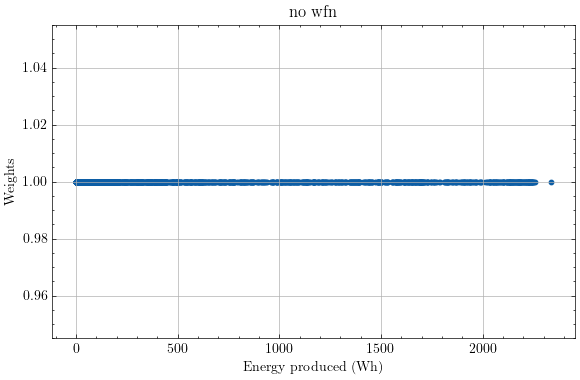

Bin amount: 26


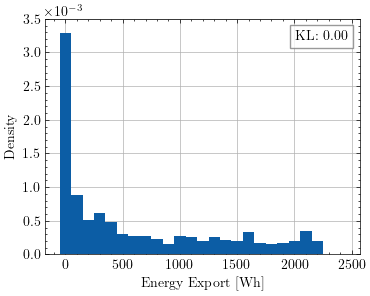

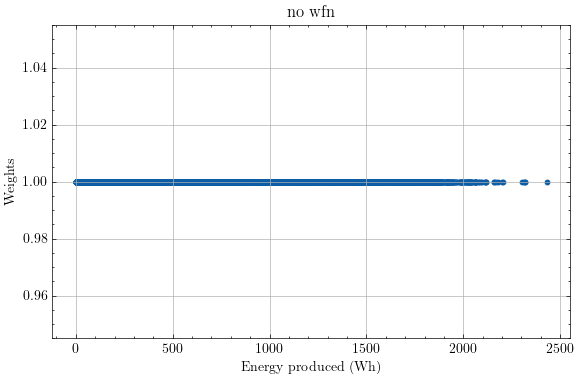

Bin amount: 26


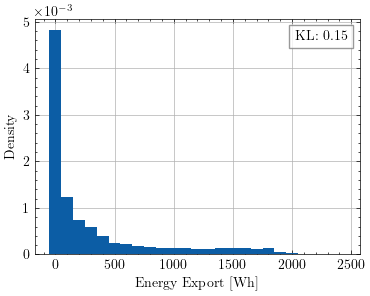

In [15]:
train_y = pd.read_csv("/home/masc12/dev/masc12-mthesis/data/poc_multiple/train_y.csv", sep=";", encoding="utf-8", parse_dates=["to"])
train_y = train_y[train_y["atday"]]

val_y = pd.read_csv("/home/masc12/dev/masc12-mthesis/data/poc_multiple/val_y.csv", sep=";", encoding="utf-8", parse_dates=["to"])
val_y = val_y[val_y["atday"]]
real_dist = val_y["energy-produced-Wh"].values

wfn = lambda x:  np.array([1] * len(x))
weights = get_sample_weights(val_y, wfn)
visualize_weighted_sampling(val_y, weights, "no wfn", "true-val-dist", real_dist, num_draws=35_000_000, density=True, sameylim=True)

weights = get_sample_weights(train_y, wfn)
visualize_weighted_sampling(train_y, weights, "no wfn", "true-train-dist", real_dist, num_draws=35_000_000, density=True)

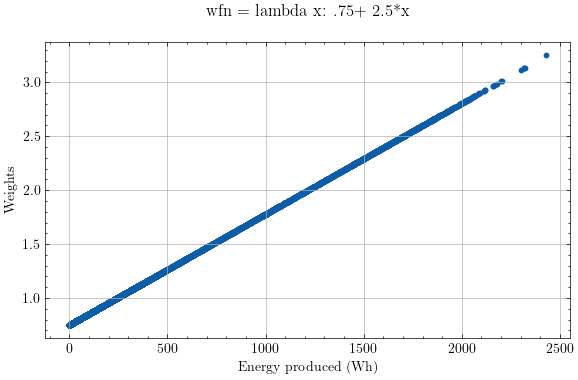

Bin amount: 26


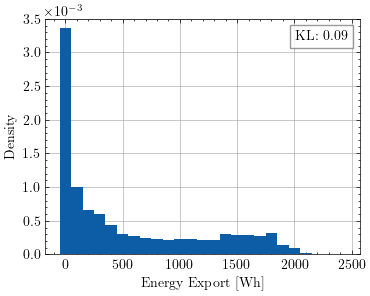

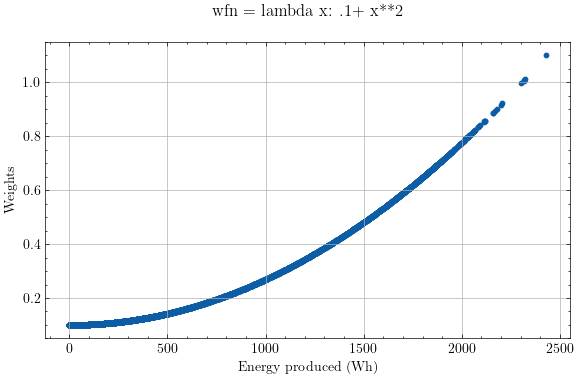

Bin amount: 26


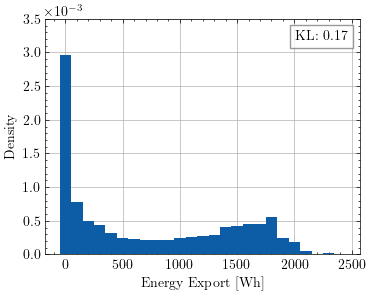

In [16]:
wfn = lambda x: .75+ 2.5*x
weights = get_sample_weights(train_y, wfn)
visualize_weighted_sampling(train_y, weights, inspect.getsource(wfn), "wfn-val-dist.75+2.5x", real_dist, num_draws=37_500_000, density=True, sameylim=True)

wfn = lambda x: .1+ x**2
weights = get_sample_weights(train_y, wfn)
visualize_weighted_sampling(train_y, weights, inspect.getsource(wfn), "wfn-val-dist.1+x2", real_dist, num_draws=37_500_000, density=True, sameylim=True)